In [15]:
import sys
print(sys.version)

import matplotlib.pyplot as plt
import sklearn.metrics
import properscoring as ps
base_dir = "/mnt/ds3lab-scratch/bhendj/data"
on_cluster = True

In [7]:
import xarray as xr
import os

if on_cluster:
    path = os.path.join(base_dir, "combiprecip", "combiprecip_201805.nc")
else:
    path = "./combiprecip_201805.nc"

weather = xr.open_mfdataset(path, combine='by_coords')

In [16]:
import xarray as xr
import pyproj

if on_cluster:
    path = os.path.join(base_dir, "cosmoe", "data.zarr", "data_ethz.zarr")
else:
    path = "./cosmoe_prec_201805.zarr"

cosmo = xr.open_zarr(path)

# Transform to the other coordinate system
src_proj = pyproj.Proj("EPSG:4326") # WSG84
dst_proj = pyproj.Proj("EPSG:21781") # CH1903 / LV03 
src_x = cosmo.lon.values
src_y = cosmo.lat.values
dst_x, dst_y = pyproj.transform(src_proj, dst_proj, src_x, src_y, always_xy=True)
cosmo = cosmo.assign_coords({"chx": (("y", "x"), dst_x) , "chy": (("y", "x"), dst_y)})


/home/mzilinec/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  app.launch_new_instance()


In [30]:
# Actual weather: (710, 640)
# Let's set this to 2018-05-01T01:00:00 (time=0)
weather_point = weather.isel(time=0, dummy=0)
target_time = weather_point['time'].values
#weather?
print(target_time)

2018-05-01T01:00:00.000000000


In [41]:
import numpy as np
# reftime: current time at time of prediction
# leadtime: number of hours after prediction time
# X, Y: (188, 127)
# chx, chy: in swiss coordinates
cosmo.isel(member=2, reftime=0, leadtime=1)['reftime']

# This is how you select the predictions at the given time
cosmo.sel(reftime=target_time - np.timedelta64(1, 'h')).isel(leadtime=1)

<xarray.Dataset>
Dimensions:   (member: 21, x: 188, y: 127)
Coordinates:
    lat       (y, x) float32 dask.array<chunksize=(127, 188), meta=np.ndarray>
    leadtime  timedelta64[ns] 01:00:00
    lon       (y, x) float32 dask.array<chunksize=(127, 188), meta=np.ndarray>
  * member    (member) int32 0 1 2 3 4 5 6 7 8 9 ... 12 13 14 15 16 17 18 19 20
    reftime   datetime64[ns] 2018-05-01
  * x         (x) int64 0 1 2 3 4 5 6 7 8 ... 180 181 182 183 184 185 186 187
  * y         (y) int64 0 1 2 3 4 5 6 7 8 ... 119 120 121 122 123 124 125 126
    chx       (y, x) float64 4.5e+05 4.522e+05 4.544e+05 ... 8.554e+05 8.577e+05
    chy       (y, x) float64 3.944e+04 3.951e+04 3.958e+04 ... 3.33e+05 3.33e+05
Data variables:
    PREC      (member, y, x) float32 dask.array<chunksize=(21, 127, 188), meta=np.ndarray>
    T_2M      (member, y, x) float32 dask.array<chunksize=(21, 127, 188), meta=np.ndarray>

In [20]:
point = cosmo.isel(member=0, reftime=0, leadtime=1, x=0, y=0)
chx, chy = point['chx'], point['chy']
chx.values, chy.values

(array(449974.33803416), array(39435.62025801))

In [21]:
real_point = weather.isel(time=0, dummy=0).sel(chx=chx, chy=chy, method='nearest')
real_point['chx'].values, real_point['chy'].values

(array(449500.), array(39500.))

In [17]:
prec_pred = point['PREC'].values
prec_real = real_point['RR'].values
sklearn.metrics.brier_score_loss([prec_real], [prec_pred])

0.6722591355674581

### Scoring points

In [42]:
pred_points = cosmo.sel(reftime=target_time - np.timedelta64(1, 'h')).isel(leadtime=1)
chx, chy = pred_points['chx'], pred_points['chy']
# This is the grid along which our predictions are placed
chx.values, chy.values;
# These are the actual predictions (ensemble_cnt, x_len, y_len)
pred_points['PREC'].values.shape

(21, 127, 188)

In [43]:
real_points = weather.isel(time=0, dummy=0).sel(chx=chx, chy=chy, method='nearest')
# These are the values of the x and y coordinates 
# of the observations that are closest to our predictions.
real_points['chx'].values, real_points['chy'].values;
# These are the observations that are closest to our predictions.
# Note that the shape is the same as the shape of predictions
#  with the ensemble dimension removed.
real_points['RR'].values.shape

(127, 188)

In [59]:
import numpy as np

def mm_to_categorical(values):
    """Converts a tensor of precipitation values from mm to categorical."""
    # no rain (< 0.1mm / h), light rain (0.1 - 1 mm/h),  
    # rain( 1 - 5 mm/h), heavy rain (5 - 10 mm/h), 
    # very heavy rain (>= 10 mm/h)
    shape = values.shape# + (5,)
    y_cat = np.zeros(shape)
    y_cat[values < 0.1]                      = 0          # 0 - no rain
    y_cat[(0.1 <= values) & (values < 1.0)]  = 1  # 1 - light rain
    y_cat[(1.0 <= values) & (values < 5.0)]  = 2  # 2 - rain
    y_cat[(5.0 <= values) & (values < 10.0)] = 3  # 3 - heavy rain
    y_cat[10.0 <= values]                    = 4  # 4 - very heavy rain
    return y_cat

def categorical_to_probs(values):
    """Aggregates a tensor of categorical predictions for an ensemble to probability scores.
    The 'ensemble' elements should be placed in the first dimension. """
    #y_probs = np.sum(values, axis=0) / values.shape[0]
    y_probs = np.zeros((5,) + values.shape[1:])
    y_probs[0] = (values == 0).sum(axis=0) / values.shape[0]
    y_probs[1] = (values == 1).sum(axis=0) / values.shape[0]
    y_probs[2] = (values == 2).sum(axis=0) / values.shape[0]
    y_probs[3] = (values == 3).sum(axis=0) / values.shape[0]
    y_probs[4] = (values == 4).sum(axis=0) / values.shape[0]
    return y_probs

# These are the predicted classes from the ensemble
y_cat = mm_to_categorical(pred_points["PREC"].values)
# These are the class probabilities after averaging the ensemble
y_probs = categorical_to_probs(y_cat)

#assert y_probs.shape == pred_points['PREC'].values.shape[1:]
print(y_probs.shape, pred_points['PREC'].values.shape)

(5, 127, 188) (21, 127, 188)


In [60]:
# These are the true classes of the data
y_true = mm_to_categorical(real_points["RR"].values)

#assert y_true.shape == y_probs.shape
y_true.shape

(127, 188)

In [61]:
# I don't understand this metric anyway
ps.threshold_brier_score(
    forecasts=pred_points['PREC'].values.swapaxes(0,-1), 
    observations=real_points['RR'].values.swapaxes(0,1), 
    threshold=0.1)

array([[0.14512472, 0.14512472, 0.14512472, ..., 0.        , 0.        ,
        0.        ],
       [0.05668934, 0.05668934, 0.05668934, ..., 0.        , 0.        ,
        0.        ],
       [0.00907029, 0.00907029, 0.03628118, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.02040816, 0.05668934,
        0.11111111],
       [0.        , 0.        , 0.        , ..., 0.02040816, 0.03628118,
        0.08163265],
       [0.        , 0.        , 0.        , ..., 0.02040816, 0.02040816,
        0.08163265]])

In [69]:
np.max(y_probs)
y_true

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [78]:
scores_0 = ps.brier_score(
    observations=(y_true == 0),
    forecasts=y_probs[0]
)
scores_1 = ps.brier_score(
    observations=(y_true == 1),
    forecasts=y_probs[1]
)
scores_2 = ps.brier_score(
    observations=(y_true == 2),
    forecasts=y_probs[2]
)
scores_3 = ps.brier_score(
    observations=(y_true == 3),
    forecasts=y_probs[3]
)
scores_4 = ps.brier_score(
    observations=(y_true == 4),
    forecasts=y_probs[4]
)

In [79]:
print(np.mean(scores_0))
print(np.mean(scores_1))
print(np.mean(scores_2))
print(np.mean(scores_3))
print(np.mean(scores_4))

0.1566902351491778
0.16221224626556938
0.012073433829889804
0.0
0.0


In [85]:
ps.crps_ensemble?
ps.crps_ensemble(
    forecasts=pred_points['PREC'].values,
    observations=real_points['RR'].values,
    axis=0
)

array([[3.4804143e-02, 4.1138113e-02, 4.6714008e-02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.7841477e-02, 3.5892360e-02, 3.0757539e-02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.7582420e-02, 4.1687779e-02, 3.9029367e-02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [8.7207183e-05, 1.0465225e-04, 1.0727538e-04, ..., 2.3547003e-02,
        2.3161970e-02, 2.3381434e-02],
       [9.4730000e-05, 1.1060404e-04, 1.2209953e-04, ..., 2.3725372e-02,
        2.2983387e-02, 2.3153739e-02],
       [1.0423706e-04, 1.2210652e-04, 1.4253589e-04, ..., 2.5853392e-02,
        2.4627328e-02, 2.4140213e-02]], dtype=float32)

In [84]:
pred_points['PREC'].values.shape, real_points['RR'].values.shape

((21, 127, 188), (127, 188))

In [94]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from pysteps import io, nowcasts, rcparams, verification
from pysteps.motion.lucaskanade import dense_lucaskanade
from pysteps.postprocessing import ensemblestats
from pysteps.utils import conversion, dimension, transformation
from pysteps.visualization import plot_precip_field

Pysteps configuration file found at: /home/mzilinec/.local/lib/python3.6/site-packages/pysteps/pystepsrc



In [97]:
reldiag = verification.reldiag_init(0.1)
verification.reldiag_accum(reldiag, pred_points['PREC'].values, real_points['RR'].values)
fig, ax = plt.subplots()
verification.plot_reldiag(reldiag, ax)
ax.set_title("Reliability diagram (+%i min)" % (n_leadtimes * timestep))
plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [96]:
verification.reldiag_accum?

In [99]:
from pysteps.postprocessing import ensemblestats
from pysteps import verification

In [106]:
probs = ensemblestats.excprob(pred_points.PREC, 0.1, ignore_nan=True)
probs.shape

(127, 188)

/home/mzilinec/.local/lib/python3.6/site-packages/pysteps/verification/plots.py:159: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  iax.set_yscale("log", basey=10)


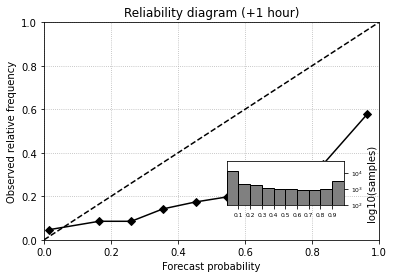

In [108]:
reldiag = verification.reldiag_init(0.1)
verification.reldiag_accum(reldiag, probs, real_points.RR.values)
fig, ax = plt.subplots()
verification.plot_reldiag(reldiag, ax)
ax.set_title("Reliability diagram (+1 hour)")
plt.show()